# iris tomography codes and other stuff

In [1]:
import sqlite3 as sql
import sys
sys.path.append('..')
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from scipy.interpolate import interp1d
from netCDF4 import num2date
units = 'days since 1858-11-17 00:00:00.000'

# import data from database

In [3]:
orbit = 20900
num_of_orbits = 2
ch = 3

db = sql.connect('/Users/anqili/Documents/Python/iris/OSIRIS_three_orbits_test.db')
cur = db.cursor()

return_column = ('data, mjd, look_ecef, sc_position_ecef, latitude, longitude, altitude')              
select_str = 'SELECT {} FROM IRI JOIN channel{} ON IRI.stw = channel{}.stw WHERE orbit>={} AND orbit<={}'
result = cur.execute(select_str.format(return_column, ch, ch, orbit, orbit+num_of_orbits))
all_image = result.fetchall()
db.close()

if len(all_image) == 0:
    print('No data for this orbit(s)')
    

print('num of images: {}'.format(len(all_image)))

l1_blob = np.array(all_image)[:,0]
mjd = np.array(all_image)[:,1].astype(float)
date = num2date(mjd, units)
sc_look_blob = np.array(all_image)[:,2]
sc_pos_blob = np.array(all_image)[:,3]
tan_lat_blob = np.array(all_image)[:,4]
tan_lon_blob = np.array(all_image)[:,5]
tan_alt_blob = np.array(all_image)[:,6]

#====unfolding blobs
l1 = np.empty((len(all_image),128))
sc_look = np.empty((len(all_image), 128, 3))
sc_pos = np.empty((len(all_image), 3))
tan_lat = np.empty((len(all_image),128))
tan_lon = np.empty((len(all_image),128))
tan_alt = np.empty((len(all_image),128))
for i in range(len(all_image)):
    l1[i,:] = np.frombuffer(l1_blob[i])
    sc_look[i,:,:] = np.frombuffer(sc_look_blob[i]).reshape(128,3)
    sc_pos[i,:] = np.frombuffer(sc_pos_blob[i])
    tan_lat[i,:] = np.frombuffer(tan_lat_blob[i])
    tan_lon[i,:] = np.frombuffer(tan_lon_blob[i])
    tan_alt[i,:] = np.frombuffer(tan_alt_blob[i])
#====construct xarray data array
pixel = np.arange(128)
l1 = xr.DataArray(l1, coords=(date, pixel), 
                  dims=('date', 'pixel'), 
                  attrs={'units':'Rayleigh??'})
sc_look = xr.DataArray(sc_look, coords=(date, pixel, ['x', 'y', 'z']), 
                       dims=('date', 'pixel', 'xyz'))
sc_pos = xr.DataArray(sc_pos, coords=(date, ['x', 'y', 'z']), dims=('date', 'xyz'))
tan_lat = xr.DataArray(tan_lat, coords=(date, pixel),
                       dims=('date', 'pixel'), attrs={'units':'degree'})
tan_lon = xr.DataArray(tan_lon, coords=(date, pixel),
                       dims=('date', 'pixel'), attrs={'units':'degree'})
tan_alt = xr.DataArray(tan_alt, coords=(date, pixel),
                       dims=('date', 'pixel'), attrs={'units':'meter'})

#====drop all dates which have nan in l1
l1 = l1.dropna('date')
sc_look = sc_look.sel(date=l1.dropna('date').date)
sc_pos = sc_pos.sel(date=l1.dropna('date').date)
tan_lat = tan_lat.sel(date=l1.dropna('date').date)
tan_lon = tan_lon.sel(date=l1.dropna('date').date)
tan_alt = tan_alt.sel(date=l1.dropna('date').date)
date = l1.dropna('date').date.data
print('num of images after removing nan: {}'.format(len(date)))

num of images: 8695
num of images after removing nan: 6787


# 1D interpolation and plotting limb radiance

/Users/anqili/anaconda3/lib/python3.6/site-packages/pandas/plotting/_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


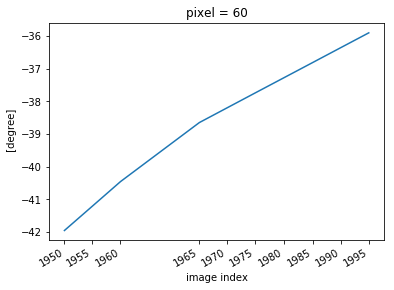

/Users/anqili/anaconda3/lib/python3.6/site-packages/matplotlib/colors.py:1012: RuntimeWarning: invalid value encountered in less_equal
  mask |= resdat <= 0


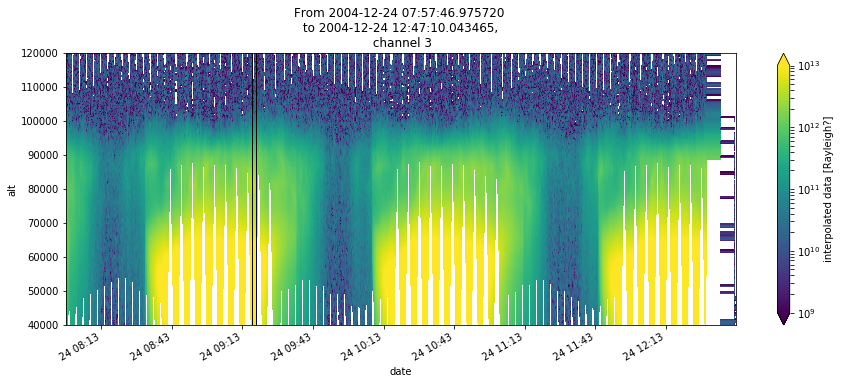

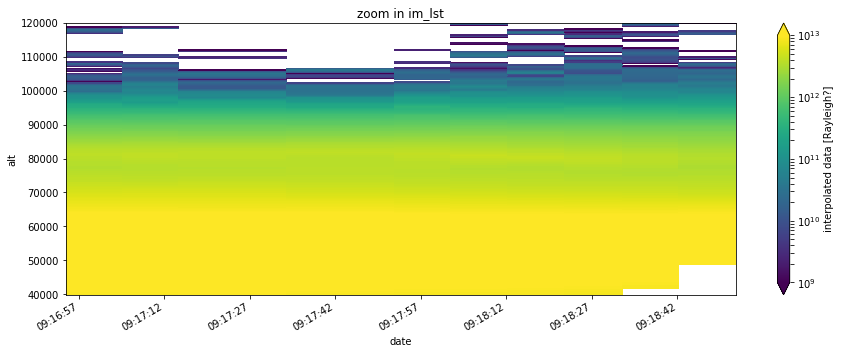

/Users/anqili/anaconda3/lib/python3.6/site-packages/matplotlib/scale.py:111: RuntimeWarning: invalid value encountered in less_equal
  out[a <= 0] = -1000


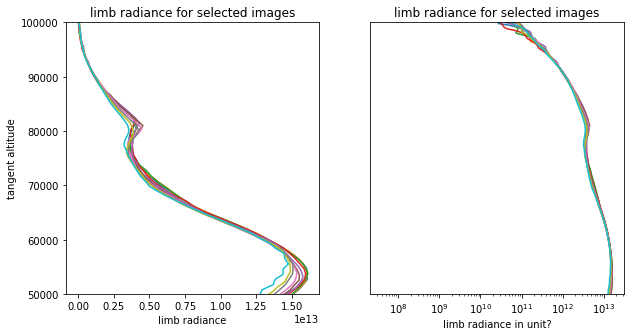

In [4]:
# choose some images to focus
im_lst = np.arange(1950,2000, 5)

tan_lat.isel(date=im_lst, pixel=60).plot()
ax = plt.gca()
ax.set_xticks(date[im_lst])
ax.set_xticklabels(im_lst)
ax.set(xlabel='image index')
plt.show()

alts_interp = np.arange(40e3, 120e3, .25e3)
data_interp = []

for (data, alt) in zip(l1, tan_alt):
    f = interp1d(alt, data, bounds_error=False)
    data_interp.append(f(alts_interp))
data_interp = xr.DataArray(data_interp, coords=(date, alts_interp), 
                           dims=('date', 'alt'))
data_interp.attrs['units'] = 'Rayleigh?'
data_interp.attrs['long_name'] = 'interpolated data'

#FIG_SIZE = (15,6)
plt.figure()
data_interp.plot(x='date', y='alt', 
                 norm=LogNorm(), 
                 vmin=1e9, vmax=1e13, 
                 size=5, aspect=3)
ax = plt.gca()
ax.set(title='From {} \n to {}, \n channel {}'.format(num2date(mjd[0],units),
       num2date(mjd[-1], units), ch))
plt.axvline(x=date[im_lst[0]], color='k', linewidth=1)
plt.axvline(x=date[im_lst[-1]], color='k', linewidth=1)
plt.show()

plt.figure()
data_interp.isel(date=im_lst).plot(x='date', y='alt', 
                 norm=LogNorm(), 
                 vmin=1e9, vmax=1e13, 
                 size=5, aspect=3)
ax = plt.gca()
ax.set(title='zoom in im_lst')
plt.show()

plt.figure(figsize=(10,5))
plt.subplot(121)
plt.plot(data_interp.isel(date=im_lst).T, alts_interp)
ax = plt.gca()
ax.set(ylabel='tangent altitude', 
       xlabel='limb radiance',
       title='limb radiance for selected images',
       ylim=[50e3,100e3])

plt.subplot(122)
plt.plot(data_interp.isel(date=im_lst).T, alts_interp)
ax = plt.gca()
ax.set(xlabel='limb radiance in unit?',
       title='limb radiance for selected images',
       ylim=[50e3,100e3])
ax.set_xscale('log')
plt.yticks([])
plt.show()

# 1D inversion for O2(1 delta) volumn emission rate


/Users/anqili/anaconda3/lib/python3.6/site-packages/xarray/core/nanops.py:161: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


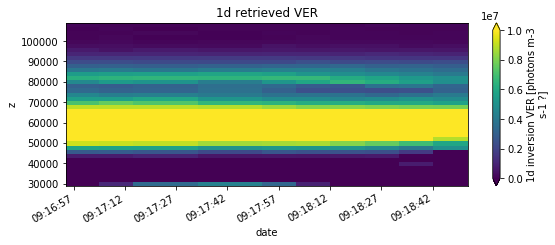

/Users/anqili/anaconda3/lib/python3.6/site-packages/matplotlib/scale.py:111: RuntimeWarning: invalid value encountered in less_equal
  out[a <= 0] = -1000


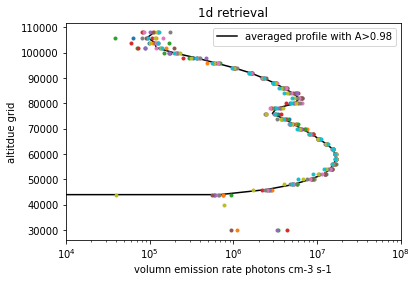

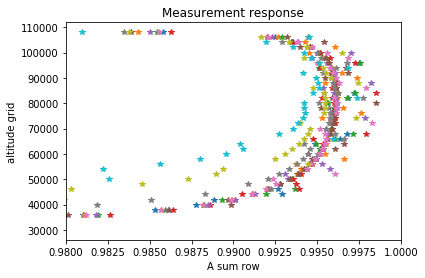

In [6]:
from oem_functions import linear_oem
from geometry_functions import pathl1d_iris

z = np.arange(30e3, 110e3, 2e3) # m
z_top = z[-1] + 2e3
result_1d = np.zeros((len(im_lst), len(z)))
xa = np.ones(len(z)) # temp
Sa = np.diag(np.ones(len(z))) *1e-9 #temp
Se = np.diag(np.ones(len(pixel))) * 30# 1e10 #30 #temporary
Ave = []
for i in range(len(im_lst)):
    h = tan_alt.isel(date=im_lst[i]).data
    K = pathl1d_iris(h, z, z_top)    
    y = l1.isel(date=im_lst[i]).data    
#    Se = np.diag(error.data[i,:]**2)
    x, A, Ss, Sm = linear_oem(K, Se, Sa, y, xa)
    result_1d[i,:] = x
    Ave.append(A.sum(axis=1)) #sum over rows 

result_1d = xr.DataArray(result_1d, 
                         coords=(date[im_lst], z), 
                         dims=('date', 'z'))
result_1d.attrs['units'] = 'photons m-3 s-1 ?'
result_1d.attrs['long_name'] = '1d inversion VER'
Ave = np.array(Ave)
result_1d_mean = result_1d.where(Ave>0.98).mean(dim='date')

# plot VER results
result_1d.plot(x='date', y='z',
#         norm=LogNorm(), 
         vmin=0, vmax=1e7, 
         size=3, aspect=3)
ax = plt.gca()
ax.set(title='1d retrieved VER')
plt.show()

plt.figure()
result_1d_mean.plot(y='z', color='k',ls='-',
                    label='averaged profile with A>0.98')
ax = plt.gca()
ax.plot(result_1d.T, z, '.')
ax.set_xscale('log')
ax.set(xlim=[1e4, 1e8],
       xlabel='volumn emission rate photons cm-3 s-1', 
       ylabel='altitdue grid',
       title='1d retrieval')
ax.legend()
plt.show()

# plot averaging kernel
plt.plot(Ave.T, z, '*')
plt.xlabel('A sum row')
plt.ylabel('altitude grid')
plt.title('Measurement response')
plt.xlim([0.98, 1])
plt.show()




# Ozone

In [7]:
from chemi import ozone_sme, ozone_textbook, oxygen_atom, jfactors, gfactor
from scipy.io import loadmat
import sys
sys.path.append('..')
MSIS = loadmat('../msisdata.mat')
zMsis = MSIS['zMsis'].squeeze() # in km
TMsis = MSIS['TMsis'] # in K
NMsis = MSIS['NMsis'] # in cm-3 
monthMsis = MSIS['monthMsis'].squeeze()
latMsis = MSIS['latMsis'].squeeze()
month = 6 #temp
lat = 1 #temp
T = interp1d(zMsis*1e3, TMsis[:,month,lat], fill_value='extrapolate')(z)
M = interp1d(zMsis*1e3, NMsis[:,month,lat], fill_value='extrapolate')(z)

#calculate O2 photosythesis rate first
zenithangle = 30 #temp
gA = gfactor(0.2*M, T, z, zenithangle)
#plt.plot(gA,z)
#plt.title('gA')


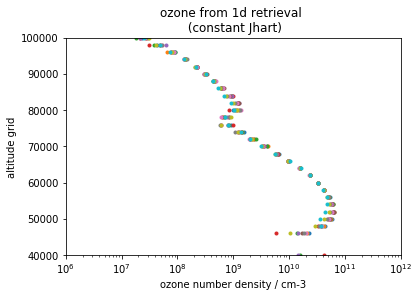

In [246]:
# with constant Jhart to calculate ozone for images within im_lst
o3 = ozone_sme(M, T, result_1d, jhart=8e-3, js=6.3e-9)
plt.figure()
ax = plt.subplot()
ax.plot(o3.T, z, '.')
ax.set_xscale('log')
ax.set(xlabel='ozone number density / cm-3',
       ylabel='altitude grid',
       title='ozone from 1d retrieval \n (constant Jhart)',
       xlim=[1e6,1e12],
       ylim=[40e3, 100e3])
plt.show()


In [16]:
# ozone onion peel
from scipy.io import loadmat
from geometry_functions import pathleng
sigma = loadmat('sigma.mat')
sO = sigma['sO'].squeeze() #sigma [cm2]
sO2 = sigma['sO2'].squeeze() #sigma [cm2]
sO3 = sigma['sO3'].squeeze() #sigma [cm2]
sN2 = sigma['sN2'].squeeze() #sigma [cm2]
irrad = sigma['irrad'].squeeze() #irradiance [cm-2 s-1]
wave = sigma['wave'].squeeze() #wavelength grid [nm]
hartrange = (wave > 210) & (wave < 310)
srcrange = (wave > 122) & (wave < 175)
lyarange = 28  # wavelength = 121.567 nm
zenithangle = 0 #temp
pathl = pathleng(z, zenithangle) * 1e2  # [m -> cm]

O2 = 0.21 * M # molec cm-3 
N2 = 0.78 * M # molec cm-3

#jO2 = irrad * sO2 * np.exp(-tau)
#jsrc = np.matmul(srcrange, jO2)
#jlya = jO2[lyarange][:]
#j3 = np.sum(jO3, axis=0)
#j2 = np.sum(jO2, axis=0)


i 38
O3 [       0.                0.                0.                0.
        0.                0.                0.                0.
        0.                0.                0.                0.
        0.                0.                0.                0.
        0.                0.                0.                0.
        0.                0.                0.                0.
        0.                0.                0.                0.
        0.                0.                0.                0.
        0.                0.                0.                0.
        0.                0.                0.         15396088.00940106]
pahtl [     0.      0.      0.      0.      0.      0.      0.      0.      0.
      0.      0.      0.      0.      0.      0.      0.      0.      0.
      0.      0.      0.      0.      0.      0.      0.      0.      0.
      0.      0.      0.      0.      0.      0.      0.      0.      0.
      0.      0.      0. 200000.]
i

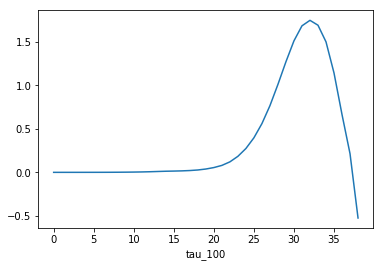

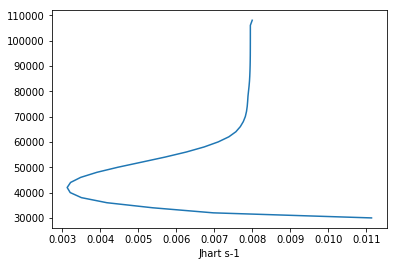

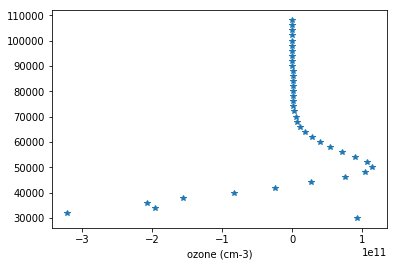

In [31]:
O2sd_ver = result_1d[1]
O3 = np.zeros(z.shape)
Jhart = np.zeros(z.shape)
jhart_max = 8e-3

# top layer with Jhart max
Jhart[-1] = jhart_max
O3[-1] = ozone_sme(M[-1], T[-1], O2sd_ver[-1], 
                   jhart=Jhart[-1], js=gA[-1])

# from the second top layers ......
test_save=[] #temp
for i in range(len(z)-2, -1, -1):
    print('i', i)
    print('O3', O3)
    print('pahtl', pathl[i+1,:])
    
#    tau = np.matmul((np.outer(sO2, O2) 
#                     + np.outer(sN2, N2) 
#                     + np.outer(sO3, O3)), pathl[i+1,:])
    
    
#    tau_o2 = sO2 * O2.dot(pathl[i+1,:])
#    tau_n2 = sN2 * N2.dot(pathl[i+1,:])
    tau_o3 = sO3 * O3.dot(pathl[i+1,:])
#    tau = tau_o2 + tau_n2 + tau_o3
    tau = tau_o3
    
    test_save.append(tau[100]) #temp
    jO3 = irrad * sO3 * np.exp(-tau)
       
    jhart = jO3[hartrange].sum()
    Jhart[i] = jhart
    O3[i] = ozone_sme(M[i], T[i], O2sd_ver[i], jhart=Jhart[i], js=gA[i])
    
    if jhart < 1e-4:
        break

plt.figure()
plt.plot(test_save)
plt.xlabel('tau_100')

plt.figure()
plt.plot(Jhart, z)
plt.xlabel('Jhart s-1')

plt.figure()
plt.plot(O3, z, '*')
plt.xlabel('ozone (cm-3)')
ax = plt.gca()
ax.set_xscale('linear')

#why tau decreases?
#why J is rising again?
#o3 is negative?

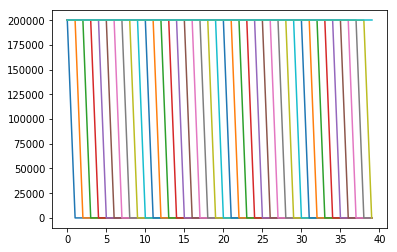

In [11]:
plt.plot(pathl)
plt.show()